##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

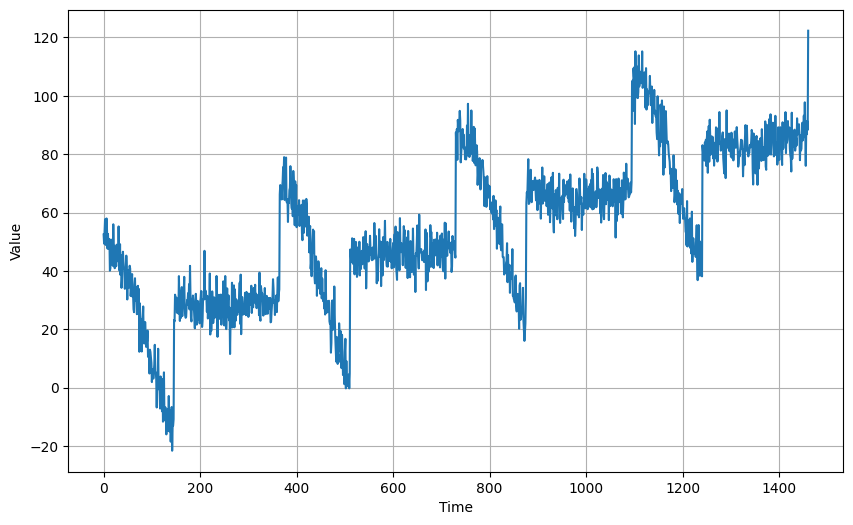

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 75ms/step - loss: 216.1872 - mae: 216.6872 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 35ms/step - loss: 154.2615 - mae: 154.7615 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 35ms/step - loss: 67.8679 - mae: 68.3679 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 34ms/step - loss: 26.3000 - mae: 26.7971 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 24.9692 - mae: 25.4665 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 36ms/step - loss: 18.8266 - mae: 19.3210 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 35ms/step - loss: 15.0550 - mae: 15.5443 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 35ms/step - loss: 13.5410 - mae: 14.0258 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 35ms/step - loss: 13.0508 - mae: 13.5376 - lr:

(1e-07, 0.0001, 0.0, 30.0)

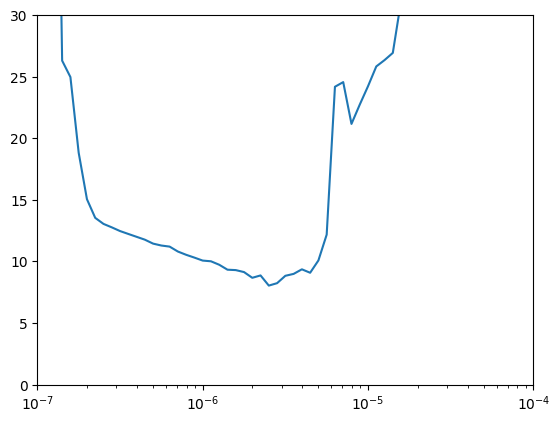

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      7/Unknown - 3s 35ms/step - loss: 13951.7812 - mae: 13952.2812

8/8 [==============================] - 7s 601ms/step - loss: 13557.9053 - mae: 13558.4053 - val_loss: 42251.9844 - val_mae: 42252.4844
Epoch 2/500
8/8 [==============================] - 1s 59ms/step - loss: 46404.3281 - mae: 46404.8281 - val_loss: 130002.7734 - val_mae: 130003.2734
Epoch 3/500
8/8 [==============================] - 1s 60ms/step - loss: 108069.1250 - mae: 108069.6172 - val_loss: 56041.6797 - val_mae: 56042.1797
Epoch 4/500
8/8 [==============================] - 1s 61ms/step - loss: 51399.3203 - mae: 51399.8203 - val_loss: 43224.9648 - val_mae: 43225.4648
Epoch 5/500
7/8 [=========================>....] - ETA: 0s - loss: 40310.5117 - mae: 40311.0117

8/8 [==============================] - 4s 560ms/step - loss: 39433.5117 - mae: 39434.0156 - val_loss: 147.8005 - val_mae: 148.3005
Epoch 6/500
8/8 [==============================] - 1s 95ms/step - loss: 67150.7969 - mae: 67151.2969 - val_loss: 92796.8828 - val_mae: 92797.3828
Epoch 7/500
8/8 [==============================] - 1s 53ms/step - loss: 87447.0781 - mae: 87447.5781 - val_loss: 99731.1484 - val_mae: 99731.6484
Epoch 8/500
8/8 [==============================] - 1s 54ms/step - loss: 51148.6836 - mae: 51149.1875 - val_loss: 31289.4727 - val_mae: 31289.9727
Epoch 9/500
8/8 [==============================] - 1s 61ms/step - loss: 35751.0586 - mae: 35751.5586 - val_loss: 51640.5352 - val_mae: 51641.0312
Epoch 10/500
8/8 [==============================] - 1s 57ms/step - loss: 34179.3984 - mae: 34179.8984 - val_loss: 21291.5703 - val_mae: 21292.0723
Epoch 11/500
8/8 [==============================] - 1s 60ms/step - loss: 39367.9023 - mae: 39368.3984 - val_loss: 6435.4688 - val_mae: 643

In [9]:
model = keras.models.load_model("my_checkpoint")

In [10]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 11ms/step


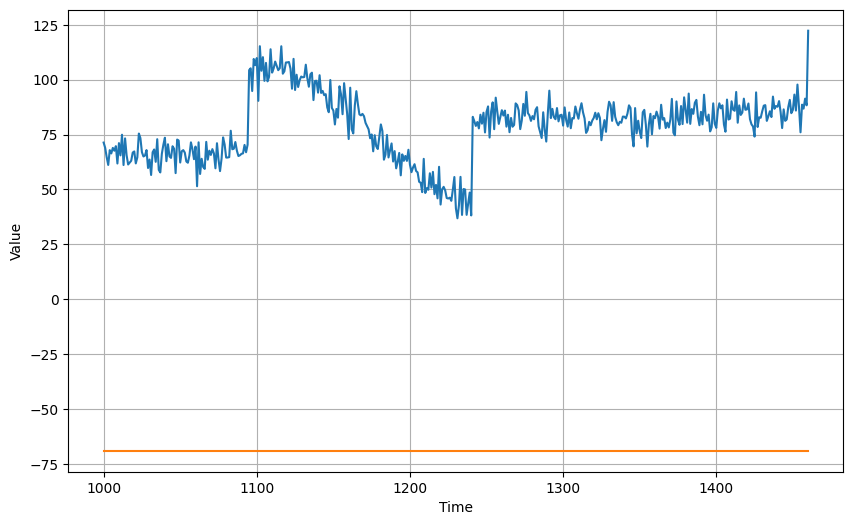

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

147.48485

## Sequence-to-Sequence Forecasting

In [13]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 41ms/step - loss: 420.3731 - mae: 420.8731 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 39ms/step - loss: 365.1454 - mae: 365.6453 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 283.6920 - mae: 284.1920 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 39ms/step - loss: 195.0766 - mae: 195.5766 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 37ms/step - loss: 97.4836 - mae: 97.9834 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 43ms/step - loss: 36.0855 - mae: 36.5814 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 39ms/step - loss: 42.4020 - mae: 42.8996 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 38ms/step - loss: 29.3161 - mae: 29.8098 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 27.8729 - mae: 28.3654 -

(1e-07, 0.0001, 0.0, 30.0)

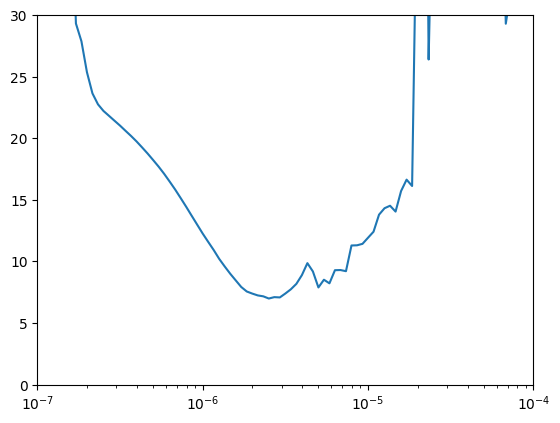

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 108ms/step - loss: 18353.3125 - mae: 18353.8145 - val_loss: 4731.1152 - val_mae: 4731.6152
Epoch 2/500
8/8 [==============================] - 1s 60ms/step - loss: 23711.6992 - mae: 23712.1973 - val_loss: 76909.4609 - val_mae: 76909.9609
Epoch 3/500
8/8 [==============================] - 1s 59ms/step - loss: 71677.7969 - mae: 71678.2891 - val_loss: 36751.5859 - val_mae: 36752.0859
Epoch 4/500
8/8 [==============================] - 1s 57ms/step - loss: 24712.1523 - mae: 24712.6543 - val_loss: 998.1763 - val_mae: 998.6763
Epoch 5/500
8/8 [==============================] - 1s 58ms/step - loss: 64468.0312 - mae: 64468.5273 - val_loss: 48400.6484 - val_mae: 48401.1523
Epoch 6/500
8/8 [==============================] - 1s 63ms/step - loss: 29753.5332 - mae: 29754.0332 - val_loss: 40443.7773 - val_mae: 40444.2734
Epoch 7/500
8/8 [==============================] - 1s 57ms/step - loss: 49837.1406 - mae: 49837.6406 - val_loss: 111638.8203 - va

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 10ms/step


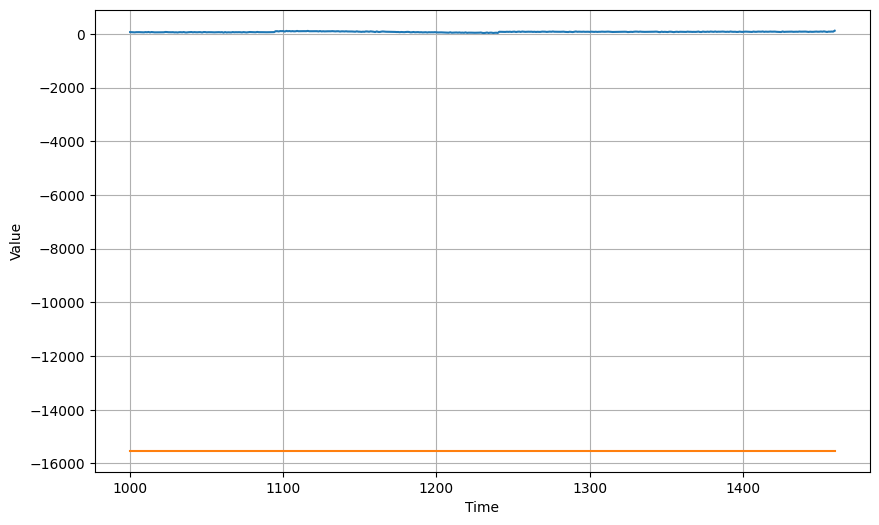

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15605.045